In [1]:
from dataclasses import dataclass

import networkx as nx 
import torch
from torch_geometric.nn import RGCNConv
from torch_geometric.utils import to_networkx

from custom_modules import DataGenerator, PersonnelScheduleEnv, RLagent, ActorMemoryWrapper, Actor, GNN

2024-09-09 11:23:29.177224: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-09 11:23:30.236762: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 11:23:30.236879: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 11:23:30.240584: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 11:23:30.937731: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-09 11:23:30.948729: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
@dataclass
class EvaluationConfig:
    output_dir = "RL_PersSched" 
    max_steps = 8
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hidden_dim = 32
    num_message_layer = 2

config = EvaluationConfig()

In [3]:
dim_employee = 1
dim_shift = 7
gnn = GNN((dim_employee, dim_shift), hidden_dim=config.hidden_dim, num_message_layer=config.num_message_layer, device=config.device)
gnn.load(config.output_dir + "/gnn_weights")

In [4]:
env = PersonnelScheduleEnv(employees=DataGenerator.get_random_employees(5,5), shifts=DataGenerator.get_week_shifts(), assignments=DataGenerator.get_empty_assignments(), device=config.device)
agent = RLagent(gnn) 
actor = Actor(agent, env=env, max_steps=config.max_steps)

In [5]:
steps = actor.execute_episode()

prob:  tensor([1.9576e-09, 1.9999e-01, 1.4126e-13, 1.4430e-05, 1.9576e-09, 1.9999e-01,
        1.4126e-13, 1.4430e-05, 1.9576e-09, 1.9999e-01, 1.4126e-13, 1.4430e-05,
        1.9576e-09, 1.9999e-01, 1.4126e-13, 1.4430e-05, 1.9576e-09, 1.9999e-01,
        1.4126e-13, 1.4430e-05], grad_fn=<SoftmaxBackward0>)
action:  17
prob:  tensor([3.3911e-05, 8.1651e-11, 2.4469e-09, 2.4997e-01, 3.3911e-05, 8.1651e-11,
        2.4469e-09, 2.4997e-01, 3.3911e-05, 8.1651e-11, 2.4469e-09, 2.4997e-01,
        3.3911e-05, 8.1651e-11, 2.4469e-09, 2.4997e-01, 5.6824e-10, 2.8026e-45,
        4.0533e-14, 8.3731e-12], grad_fn=<SoftmaxBackward0>)
action:  3
prob:  tensor([7.0556e-06, 0.0000e+00, 1.2877e-10, 1.4013e-45, 3.3330e-01, 8.0253e-07,
        2.4050e-05, 7.8641e-07, 3.3330e-01, 8.0253e-07, 2.4050e-05, 7.8641e-07,
        3.3330e-01, 8.0253e-07, 2.4050e-05, 7.8641e-07, 5.5852e-06, 3.4727e-41,
        3.9839e-10, 2.7528e-32], grad_fn=<SoftmaxBackward0>)
action:  12
prob:  tensor([3.3683e-34, 0.0000e+00, 2.

In [6]:
print("Is terminated: ", env.terminated())
print("Planning: ")
env.get_current_planning()

Is terminated:  True
Planning: 


{0: [3, 1], 1: [4, 1], 2: [3, 4], 3: [0, 2]}

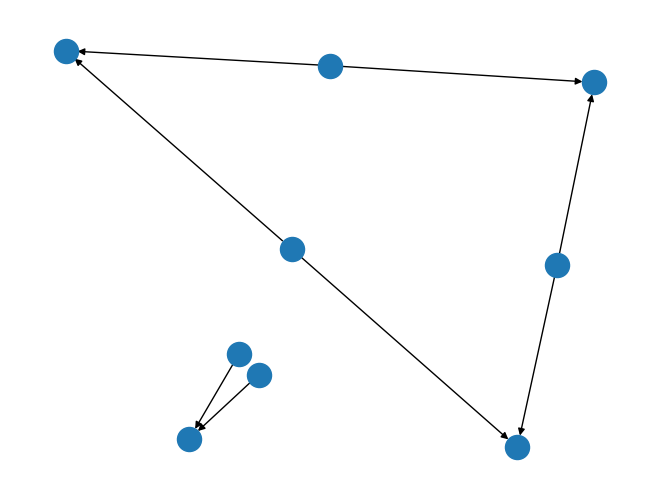

In [7]:
g=to_networkx(env.state)
nx.draw(g)